In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
%reset -sf

In [7]:
import importlib
import Deproject_v1_0 
from Deproject_test import *
from Deproject_plots import *
import matplotlib.pyplot as plt
from scipy import sparse as scisp
from scipy.optimize import approx_fprime
import os
import cProfile
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from timeit import default_timer as timer

from astropy.io.ascii import read as tableread
import astropy.units as u
import astropy.coordinates as coord

coord.Galactic()
%cd /home/mikkola/Documents/DeprojectionProject/

/home/mikkola/Documents/DeprojectionProject


## Generate  fake Galactic samples

From simulated galaxy:

In [8]:
%cd /home/mikkola/Documents/DeprojectionProject/faststats/faststats/
from fastkde import *
def kdeplot(x,y,grid,no_c,bw_a):
    Z,ax = fastkde(x,y,gridsize=grid,nocorrelation=no_c,adjust=bw_a)#,weights,adjust)
    xlen,ylen = np.shape(Z)
    X,Y = np.meshgrid(np.linspace(ax[0],ax[1],xlen),np.linspace(ax[0],ax[1],ylen))
    return X,Y,Z
%cd /home/mikkola/Documents/DeprojectionProject/

/home/mikkola/Documents/DeprojectionProject/faststats/faststats
/home/mikkola/Documents/DeprojectionProject


Loading data

In [9]:
N = 5000 #Number of stars we want to use in our sample
dat = np.load('DATA/simgal.npy')

Select a sample around with radius 2 kpc around 8 kpc

In [10]:
x,y,z,vx,vy,vz = dat
R = np.sqrt((x-8)**2 + y**2)
snbh = R < 2
dat = dat[:,snbh]
I = np.random.randint(low=0,high=np.sum(snbh),size=N)

x,y,z,vx,vy,vz = dat[:,I]

# Center x, y and vy, so they look like they're relative to the LSR
x = x - np.median(x)
y = y - np.median(y)
vy = vy - np.median(vy)

Prepare for astropy

In [11]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [12]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)


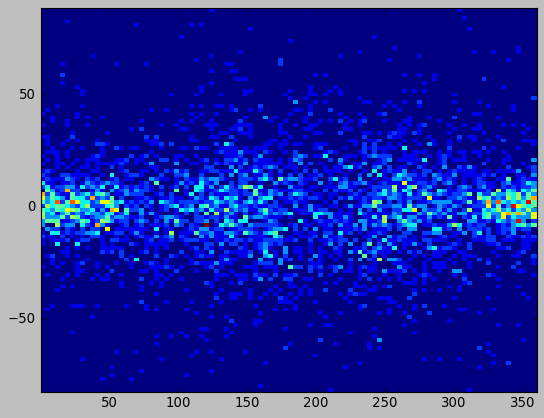

In [13]:
plt.hist2d(np.array(sample.l),np.array(sample.b),100)
plt.show()

True distribution

In [14]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

In [17]:
n = np.array([40,40,40])
dv = np.array([5,5,5])
vmin = np.array([-100,-100,-100])

In [18]:
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

sigma = np.sqrt(sigma2)
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)

sanity_check(pvals,rhatvals,phi0,vmin,dv,n)


DB98 mean                  : ===> [3.856585 2.551463 0.101437]
computed f(v) mean         : ===> [3.450227 2.550811 0.101429]
DB98 dispersions           : ===> [41.334711 22.917104 21.673416]
Computed f(v) dispersions  : ===> [39.075333 22.913982 21.672503]




In [68]:
alpha_guess = 1e-8

v_guess = np.array([1,1,1])
disp_guess = np.array([22,17,30])

t0 = timer()
#phi_hs, phiall, fmin_it
mxl, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess)
#mxl, phi_all, fmin_it = max_L(alpha, pvals, rhatvals, vmin, dv, n, noniso=non_iso)
time = str((timer() - t0)/60)
print(time + ' mins')

# cProfile.run('max_L(8e-14, pvals, rhatvals, vmin, dv, n,v0_guess=v_guess, disp_guess=disp_guess)')

sanity_check(pvals,rhatvals,mxl,vmin,dv,n)

Run requires: 0.32 GB (120.0 GB available) | Block size = 234375
Fast Numpy Kvals run possible, running...

Finished kvals.

Optimization terminated successfully.
         Current function value: 10.384032
         Iterations: 3060
         Function evaluations: 9183
         Gradient evaluations: 9183
5.103671288987001 mins

DB98 mean                  : ===> [3.856585 2.551463 0.101437]
computed f(v) mean         : ===> [2.656209 0.957979 0.311405]
DB98 dispersions           : ===> [41.334711 22.917104 21.673416]
Computed f(v) dispersions  : ===> [50.664267 25.650612 20.887614]




In [ ]:
print('#'*80)
print('#'*80)
print('#'*80)
print('#'*80)
print('#'*80)
print('#'*80)

In [ ]:
dx, dy = dv[0], dv[1]
vxmin, vymin = vmin[0], vmin[1]
nx, ny = n[0], n[1]
vxmax, vymax = vxmin+nx*dx,vymin+ny*dy

x0, y0 = vxmin, vymin
x1, y1 = vxmax, vymax

xbins = np.arange(x0,x1+dx,dx)
ybins = np.arange(y0,y1+dy,dy)

xc = (xbins[1:]+xbins[:-1])/2
yc = (ybins[1:]+ybins[:-1])/2

[X,Y] = np.meshgrid(xc,yc);

fv = np.exp(mxl)

fvlog = np.log10(fv+1)

twodfv = np.sum(fv,axis=2)
plt.figure()
plt.contourf(X,Y,twodfv.T,40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.contour(X,Y,twodfv.T,10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()

X2,Y2,Z = kdeplot(np.array(vx),np.array(vy),(50,50),False,2)
plt.figure()
plt.contourf(X2,Y2,Z.T,40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.contour(X2,Y2,Z.T,10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.contourf(X,Y,np.log10(twodfv.T),40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.contour(X,Y,np.log10(twodfv.T),10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.show()

## Is a real dataset also slow in jupyter?

In [5]:
def process_input(file_): #Function that reads the input file if any
    h_file = []
    input_ = open(file_, 'r')
    for line in input_:
        if line.find("#") != -1:
            continue
        elif line.find("\n") == 0:
            continue
        else:
            h_file.append(line.split('\t'))
    return h_file

guessfile = 'vars.ini'#The vars.ini file
vars_ = process_input(guessfile)
N = int(vars_[0][0])
n = np.array(vars_[1][0].split(',')[:],dtype=int)
vmin = np.array(vars_[2][0].split(',')[:],dtype=float)
dv = np.array(vars_[3][0].split(',')[:],dtype=float)
use_guess = bool(int(vars_[4][0]))
non_iso = bool(int(vars_[5][0]))
v_guess = np.array(vars_[6][0].split(',')[:],dtype=float)
disp_guess = np.array(vars_[7][0].split(',')[:],dtype=float)
alpha = float(vars_[8][0])
datafile = vars_[9][0].rstrip('\n')
logging = bool(int(vars_[5][0]))

data_raw = tableread('DATA/'+str(datafile))
dist = 1000/data_raw['parallax']*u.pc        
RA = (data_raw['ra']*u.degree)
DEC = (data_raw['dec']*u.degree)
plx = (data_raw['parallax']*u.mas)
pm_RA = (data_raw['pmra']*u.mas/u.yr)
pm_DEC = (data_raw['pmdec']*u.mas/u.yr)
print("Sample has " + str(len(dist)) + " stars")



sample_icrs = coord.ICRS(ra = RA, dec = DEC, pm_ra_cosdec = pm_RA, pm_dec = pm_DEC,distance=dist)

sample = sample_icrs.transform_to(coord.Galactic)

pvals, rhatvals = calc_p_rhat(sample)

Sample has 37475 stars


In [ ]:
# From running in terminal
#fmin its    : 1095
#Time needed : 15.51415611108144 mins

t0 = timer()
if use_guess:
    mxl, phi_all, fmin_it = max_L(alpha, pvals, rhatvals, vmin, dv, n,v0_guess=v_guess,
                                  disp_guess=disp_guess, noniso=non_iso)
elif not use_guess:
    mxl, phi_all, fmin_it = max_L(alpha, pvals, rhatvals, vmin, dv, n, noniso=non_iso)
    
print(str((timer() - t0)/60) + ' mins')

In [ ]:
def string(term_row, jup_row):
    if term_row != jup_row:
        s1 = '!!!\n'
        s2 = ''.rjust(10) + 'module:'.rjust(10) + 'ver:'.rjust(10) + 'nick:'.rjust(10) + '\n'
        s3 = 'Term: '.rjust(10) + "".join([s.rjust(10) for s in term_row[0]]) + '\n'
        s4 = 'Jup: '.rjust(10) + "".join([s.rjust(10) for s in jup_row[0]]) + '\n'
        line = s1 + s2 + s3 + s4
        return line
    
def pure_jup_string(jup_row):
    s1 = 'Jup only\n'
    s2 = ''.rjust(10) + 'module:'.rjust(10) + 'ver:'.rjust(10) + 'nick:'.rjust(10) + '\n'
    s3 = 'Jup: '.rjust(10) + "".join([s.rjust(10) for s in jup_row]) + '\n'
    line = s1 + s2 + s3
    return line

def pure_term_string(term_row):
    s1 = 'Term only\n'
    s2 = ''.rjust(10) + 'module:'.rjust(10) + 'ver:'.rjust(10) + 'nick:'.rjust(10) + '\n'
    s3 = 'Term: '.rjust(10) + "".join([s.rjust(10) for s in term_row]) + '\n'
    line = s1 + s2 + s3
    return line

In [ ]:
def read_mods(txtfile):
    txt = open(txtfile, 'r')
    rows = txt.read().split('\n')[:-1]
    nrows = len(rows)
    mods_array = np.zeros((nrows,3))
    rows = [rows[i].split() for i in range(nrows)]
    return rows

term_rows = read_mods('mods_terminal.txt')
jup_rows  = read_mods('mods_jupyter.txt')

term_mods = [term_rows[i][0] for i in range(len(term_rows))]
jup_mods  = [jup_rows[i][0] for i in range(len(jup_rows))]

In [ ]:
for mod in jup_mods:
    i_jup  = jup_mods.index(mod)
    if mod in term_mods:
        i_term = term_mods.index(mod)            
        line = string(term_rows[i_term], jup_rows[i_jup])
        #if line != None:
        #    print(line)  
    else: 
        line = pure_jup_string(jup_rows[i_jup])
       # print(line)

In [ ]:
for mod in term_mods:
    i_term  = (term_mods == mod)
    if mod in jup_mods:
        i_jup = (jup_mods == mod)

        line = string(term_rows[i_term], jup_rows[i_jup])
    #    if line != None:
     #       print(line)    
    else: 
        line = pure_term_string(term_rows[i_term])
     #   print(line)

In [ ]:
np.prod(n)

In [ ]:
nx, ny, nz = n; nx*ny*nz

In [5]:
len(pvals)

37475